In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_ei_basic2
from bo_functions import ExactGPModel
from bo_functions import calc_GP_outputs
from bo_functions import train_GP_model

from bo_plotters import plot_hyperparams
from bo_plotters import y_plotter_basic2
from bo_plotters import stdev_plotter_basic2
from bo_plotters import stdev_plotter_basic
from bo_plotters import ei_plotter_basic
from bo_plotters import ei_plotter_basic2

In [2]:
#Pull x data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
# print(x)

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])

In [4]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_T, train_sse, likelihood)

In [5]:
#Training the GP Model
iterations = 300
train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
noise_list = train_GP[0]
lengthscale_list = train_GP[1]
outputscale_list = train_GP[2]

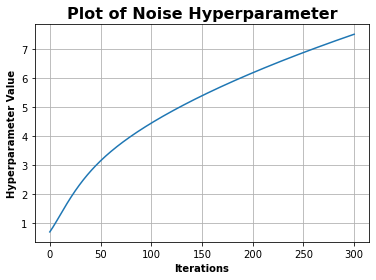

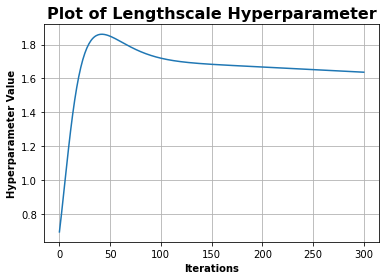

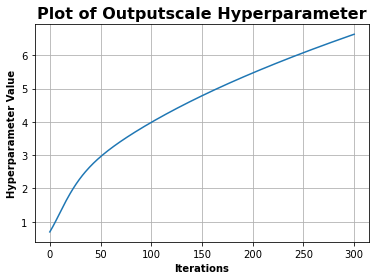

In [6]:
#Plot hyperparameters vs iteration
noise_title = "Noise Hyperparameter"
lengthscale_title = "Lengthscale Hyperparameter"
outputscale_title = "Outputscale Hyperparameter"
plot_hyperparams(iterations, noise_list,noise_title)
plot_hyperparams(iterations, lengthscale_list,lengthscale_title)
plot_hyperparams(iterations, outputscale_list,outputscale_title)

In [7]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval()

p=10
#Define Testing Space
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]
theta_space = torch.tensor(theta_mesh.T.reshape(-1, 2)) #25 x 2
# print(test_T)

In [8]:
#Loop over Theta1
ei = np.zeros((p,p))
sse = np.zeros((p,p))
var = np.zeros((p,p))
stdev = np.zeros((p,p))
for i in range(p):
    #Loop over Theta_2
    for j in range(p):
        eval_point = []
        eval_point.append([theta1_mesh[i,j],theta2_mesh[i,j]])
        eval_point = np.array(eval_point)
        GP_Outputs = calc_GP_outputs(model, likelihood, eval_point[0:1])
        model_sse = GP_Outputs[3].numpy()[0] #1xn
#         print(model_sse)
        model_variance= GP_Outputs[1].numpy()[0] #1xn
        sse[i,j] = model_sse
        var[i,j] = model_variance
        stdev[i,j] = np.sqrt(model_variance)
        best_error = max(train_sse)
#         print(best_error)
        #PDF and CDF both calculated as 0 currently
        ei[i,j] = calc_ei_basic2(best_error,model_sse,model_variance)

print(ei) 
# print(sse)
# print(stdev)



stdev 3.2712591062790985
z tensor(-91.1312, dtype=torch.float64)
term 1 tensor(-0., dtype=torch.float64)
term 2 0.0
stdev 3.1707630616430875
z tensor(-95.0463, dtype=torch.float64)
term 1 tensor(-0., dtype=torch.float64)
term 2 0.0
stdev 3.1263727150677014
z tensor(-98.5879, dtype=torch.float64)
term 1 tensor(-0., dtype=torch.float64)
term 2 0.0
stdev 3.1378366962758286
z tensor(-101.1617, dtype=torch.float64)
term 1 tensor(-0., dtype=torch.float64)
term 2 0.0
stdev 3.1808097465192624
z tensor(-102.8377, dtype=torch.float64)
term 1 tensor(-0., dtype=torch.float64)
term 2 0.0
stdev 3.2282810381633893
z tensor(-103.8787, dtype=torch.float64)
term 1 tensor(-0., dtype=torch.float64)
term 2 0.0
stdev 3.2704928879011814
z tensor(-104.2122, dtype=torch.float64)
term 1 tensor(-0., dtype=torch.float64)
term 2 0.0
stdev 3.3167920709351297
z tensor(-103.4503, dtype=torch.float64)
term 1 tensor(-0., dtype=torch.float64)
term 2 0.0
stdev 3.380940222427028
z tensor(-101.3667, dtype=torch.float64)
te

In [9]:
#Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
argmin = np.array(np.where(sse == np.amin(sse)))
Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))
print("The GP predicts that Theta1 =",Theta_Opt_GP[0],"and Theta2 =", Theta_Opt_GP[1])

#calculates best_error and expected improvement
##This works if all the values aren't zero
# argmax = np.array(np.where(ei == np.amax(ei)))
# Theta_1_Best = float(theta1_mesh[argmax[0],argmax[1]])
# Theta_2_Best = float(theta2_mesh[argmax[0],argmax[1]])
# Theta_Best = np.array((Theta_1_Best,Theta_2_Best))
# print("The GP estimates the highest EI is at \nTheta1, Theta2 = \n ")
# print(Theta_Best)

The GP predicts that Theta1 = 1.1111111111111107 and Theta2 = -1.5555555555555556


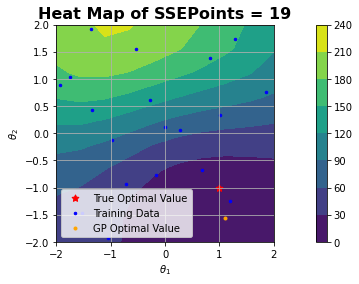

In [10]:
title = "SSE"
Theta_True = np.array([1,-1])
y_plotter_basic2(theta_mesh, sse, Theta_True, Theta_Opt_GP, train_T,title,plot_train=True)

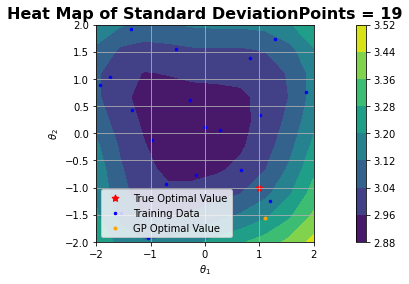

In [11]:
stdev_plotter_basic2(theta_mesh, stdev,Theta_True, Theta_Opt_GP,train_T,plot_train=True)

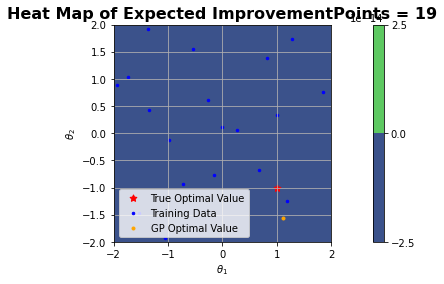

In [12]:
ei_plotter_basic2(theta_mesh, ei, Theta_True, Theta_Opt_GP,train_T,plot_train=True)